In [1]:
# Importing libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io
import math

In [2]:
# Call API and create dataframe

response = requests.get("https://api.covid19india.org/csv/latest/state_wise_daily.csv")
df = pd.read_csv(io.StringIO(response.text), delimiter=",")
display(df)

,Date,Date_YMD,Status,TT,AN,AP,AR,AS,BR,CH,...,PB,RJ,SK,TN,TG,TR,UP,UT,WB,UN
0,14-Mar-20,2020-03-14,Confirmed,81,0,1,0,0,0,0,...,1,3,0,1,1,0,12,0,0,0
1,14-Mar-20,2020-03-14,Recovered,9,0,0,0,0,0,0,...,0,1,0,0,0,0,4,0,0,0
2,14-Mar-20,2020-03-14,Deceased,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15-Mar-20,2020-03-15,Confirmed,27,0,0,0,0,0,0,...,0,1,0,0,2,0,1,0,0,0
4,15-Mar-20,2020-03-15,Recovered,4,0,0,0,0,0,0,...,0,2,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1207,20-Apr-21,2021-04-20,Recovered,166656,31,3116,15,279,3577,443,...,3198,3207,4,6250,2209,16,14391,734,4805,0
1208,20-Apr-21,2021-04-20,Deceased,2021,0,35,0,3,51,4,...,60,64,0,48,18,0,162,27,46,0
1209,21-Apr-21,2021-04-21,Confirmed,315735,24,9716,73,1665,12222,622,...,4953,14622,50,11681,6542,0,33106,4807,10784,0
1210,21-Apr-21,2021-04-21,Recovered,179427,33,3359,16,297,4774,454,...,2727,3765,2,7071,2887,0,14198,894,5616,0


In [3]:
# State codes

state_codes = list(df.columns)[4:-1]
print("Number of States & UTs:", len(state_codes))
print(state_codes)

Number of States & UTs: 37
['AN', 'AP', 'AR', 'AS', 'BR', 'CH', 'CT', 'DN', 'DD', 'DL', 'GA', 'GJ', 'HR', 'HP', 'JK', 'JH', 'KA', 'KL', 'LA', 'LD', 'MP', 'MH', 'MN', 'ML', 'MZ', 'NL', 'OR', 'PY', 'PB', 'RJ', 'SK', 'TN', 'TG', 'TR', 'UP', 'UT', 'WB']


In [4]:
# Handle negative counts

negative_count = 0

for i in range(len(df)):
    for j in range(4, 41):
        if df.iloc[i, j] < 0:
            negative_count += 1
            if j == 4:
                df.iloc[i, j] = 0
            elif j == 5:
                df.iloc[i, j] = math.floor((df.iloc[i, j-1].sum() + df.iloc[i, j+1].sum()) / 2)
            elif j == 6:
                df.iloc[i, j] = math.floor((df.iloc[i, j-2:j].sum() + df.iloc[i, j+1:j+3].sum()) / 4)
            elif j == 38:
                df.iloc[i, j] = math.floor((df.iloc[i, j-2:j].sum() + df.iloc[i, j+1:j+3].sum()) / 4)
            elif j == 39:
                df.iloc[i, j] = math.floor((df.iloc[i, j-1].sum() + df.iloc[i, j+1].sum()) / 2)
            elif j == 40:
                avg = df.iloc[i, j-7:j].mean()
                df.iloc[i, j] = math.floor((avg / df.iloc[i, j-7]) * avg)
            else:
                df.iloc[i, j] = math.floor((df.iloc[i, j-3:j].sum() + df.iloc[i, j+1:j+4].sum()) / 6)

print("Total negative count:", negative_count)

Total negative count: 16


In [5]:
# Create active cases dataframe

active = pd.DataFrame(columns=df.columns)

running_confirmed = [0] * len(df.loc[0][3:])
running_recovered = [0] * len(df.loc[1][3:])
running_deceased = [0] * len(df.loc[2][3:])

for row in range(len(df)):
    if df.loc[row]["Status"] == "Confirmed":
        running_confirmed += df.loc[row][3:]
    elif df.loc[row]["Status"] == "Recovered":
        running_recovered += df.loc[row][3:]
    else:
        running_deceased += df.loc[row][3:]
        active.loc[len(active)] = [df.loc[row]["Date"], df.loc[row]["Date_YMD"], "Active"] + list(running_confirmed - running_recovered - running_deceased)

active = active.infer_objects()
display(active)

,Date,Date_YMD,Status,TT,AN,AP,AR,AS,BR,CH,...,PB,RJ,SK,TN,TG,TR,UP,UT,WB,UN
0,14-Mar-20,2020-03-14,Active,70,0,1,0,0,0,0,...,1,2,0,1,1,0,8,0,0,0
1,15-Mar-20,2020-03-15,Active,93,0,1,0,0,0,0,...,1,1,0,1,2,0,9,0,0,0
2,16-Mar-20,2020-03-16,Active,107,0,1,0,0,0,0,...,1,1,0,0,3,0,9,1,0,0
3,17-Mar-20,2020-03-17,Active,116,0,1,0,0,0,0,...,1,1,0,0,4,0,10,1,1,0
4,18-Mar-20,2020-03-18,Active,153,0,1,0,0,0,0,...,2,4,0,1,12,0,12,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,17-Apr-21,2021-04-17,Active,1799941,126,40469,105,6033,39498,3414,...,32615,59999,-646,65635,33004,575,170057,17930,45270,0
400,18-Apr-21,2021-04-18,Active,1929545,131,44686,122,6507,44701,3625,...,34306,67135,-546,70391,36527,637,191455,19840,49608,0
401,19-Apr-21,2021-04-19,Active,2030434,150,48053,176,7555,49528,3804,...,35427,76641,-540,75116,38644,654,208521,21444,53388,0
402,20-Apr-21,2021-04-20,Active,2156122,164,53889,222,8924,56355,3959,...,36825,85571,-453,79804,42343,698,223542,23695,58356,0


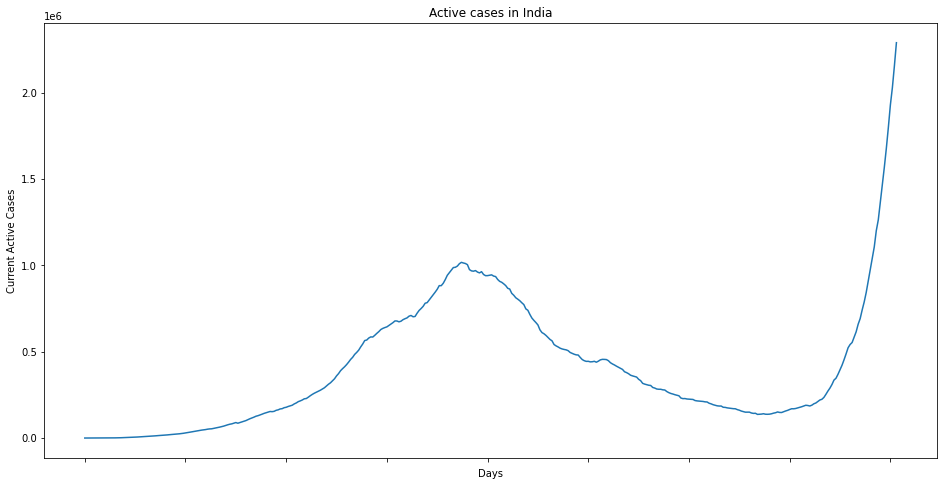

In [6]:
# Active cases in India

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
g = sns.lineplot(data=active["TT"], dashes=False)
g.set(xticklabels=[])
g.set(title="Active cases in India")
g.set(xlabel="Days")
g.set(ylabel="Current Active Cases")
plt.show()

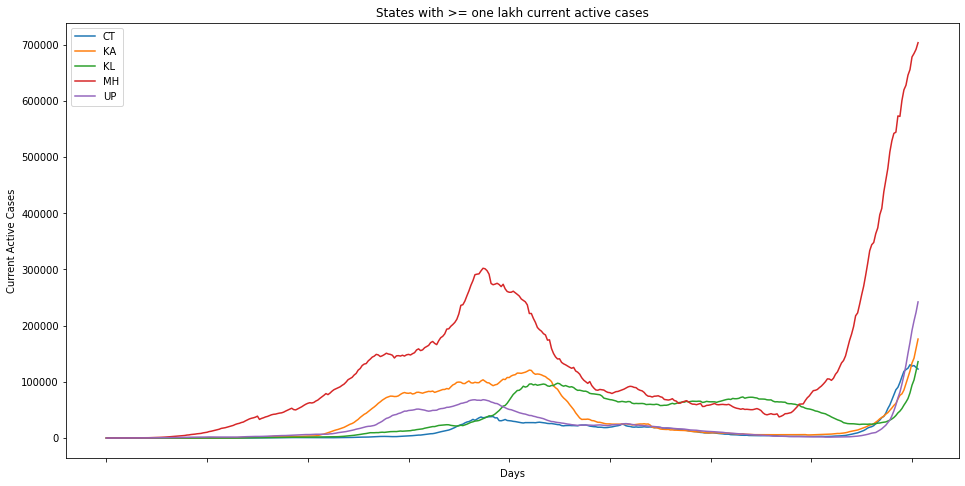

In [7]:
# States with >= one lakh current active cases

states = []
for state in state_codes:
    if active.loc[len(active)-1][state] >= 100000:
        states.append(state)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
g1 = sns.lineplot(data=active[states], dashes=False)
g1.set(xticklabels=[])
g1.set(title="States with >= one lakh current active cases")
g1.set(xlabel="Days")
g1.set(ylabel="Current Active Cases")
plt.show()

In [8]:
# Segregate confirmed, recovered and deceased cases

confirmed = df.loc[df["Status"] == "Confirmed"]
recovered = df.loc[df["Status"] == "Recovered"]
deceased = df.loc[df["Status"] == "Deceased"]

display(confirmed)
display(recovered)
display(deceased)

,Date,Date_YMD,Status,TT,AN,AP,AR,AS,BR,CH,...,PB,RJ,SK,TN,TG,TR,UP,UT,WB,UN
0,14-Mar-20,2020-03-14,Confirmed,81,0,1,0,0,0,0,...,1,3,0,1,1,0,12,0,0,0
3,15-Mar-20,2020-03-15,Confirmed,27,0,0,0,0,0,0,...,0,1,0,0,2,0,1,0,0,0
6,16-Mar-20,2020-03-16,Confirmed,15,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
9,17-Mar-20,2020-03-17,Confirmed,11,0,0,0,0,0,0,...,0,0,0,0,1,0,2,0,1,0
12,18-Mar-20,2020-03-18,Confirmed,37,0,0,0,0,0,0,...,1,3,0,1,8,0,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1197,17-Apr-21,2021-04-17,Confirmed,260895,42,7224,19,876,7870,431,...,4431,9046,72,9344,4446,58,27334,2757,7713,0
1200,18-Apr-21,2021-04-18,Confirmed,275063,59,6582,20,639,8690,625,...,4900,10262,105,10723,5093,69,30566,2630,8419,0
1203,19-Apr-21,2021-04-19,Confirmed,257003,31,5963,65,1367,7487,612,...,4622,11967,9,10941,4009,32,28211,2160,8426,0
1206,20-Apr-21,2021-04-20,Confirmed,294365,45,8987,61,1651,10455,602,...,4656,12201,91,10986,5926,60,29574,3012,9819,0


,Date,Date_YMD,Status,TT,AN,AP,AR,AS,BR,CH,...,PB,RJ,SK,TN,TG,TR,UP,UT,WB,UN
1,14-Mar-20,2020-03-14,Recovered,9,0,0,0,0,0,0,...,0,1,0,0,0,0,4,0,0,0
4,15-Mar-20,2020-03-15,Recovered,4,0,0,0,0,0,0,...,0,2,0,0,1,0,0,0,0,0
7,16-Mar-20,2020-03-16,Recovered,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
10,17-Mar-20,2020-03-17,Recovered,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
13,18-Mar-20,2020-03-18,Recovered,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198,17-Apr-21,2021-04-17,Recovered,138209,36,2332,6,149,1804,438,...,2615,2823,4,5263,1414,11,7831,802,3426,0
1201,18-Apr-21,2021-04-18,Recovered,143839,54,2343,3,159,3460,411,...,3141,3084,5,5925,1555,7,9041,708,4053,0
1204,19-Apr-21,2021-04-19,Recovered,154357,12,2569,11,312,2619,429,...,3418,2408,3,6172,1878,15,10978,532,4608,0
1207,20-Apr-21,2021-04-20,Recovered,166656,31,3116,15,279,3577,443,...,3198,3207,4,6250,2209,16,14391,734,4805,0


,Date,Date_YMD,Status,TT,AN,AP,AR,AS,BR,CH,...,PB,RJ,SK,TN,TG,TR,UP,UT,WB,UN
2,14-Mar-20,2020-03-14,Deceased,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,15-Mar-20,2020-03-15,Deceased,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,16-Mar-20,2020-03-16,Deceased,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,17-Mar-20,2020-03-17,Deceased,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,18-Mar-20,2020-03-18,Deceased,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199,17-Apr-21,2021-04-17,Deceased,1498,1,15,0,2,34,2,...,62,37,0,39,12,0,120,37,34,0
1202,18-Apr-21,2021-04-18,Deceased,1620,0,22,0,6,27,3,...,68,42,0,42,15,0,127,12,28,0
1205,19-Apr-21,2021-04-19,Deceased,1757,0,27,0,7,41,4,...,83,53,0,44,14,0,167,24,38,0
1208,20-Apr-21,2021-04-20,Deceased,2021,0,35,0,3,51,4,...,60,64,0,48,18,0,162,27,46,0


In [9]:
# Calculate total active, confirmed, recovered and deceased cases

print("Total Active Cases:", list(active["TT"])[-1])
print("Total Confirmed Cases:", confirmed["TT"].sum())
print("Total Recovered Cases:", recovered["TT"].sum())
print("Total Deceased Cases:", deceased["TT"].sum())

Total Active Cases: 2290329
Total Confirmed Cases: 15924265
Total Recovered Cases: 13449260
Total Deceased Cases: 184676


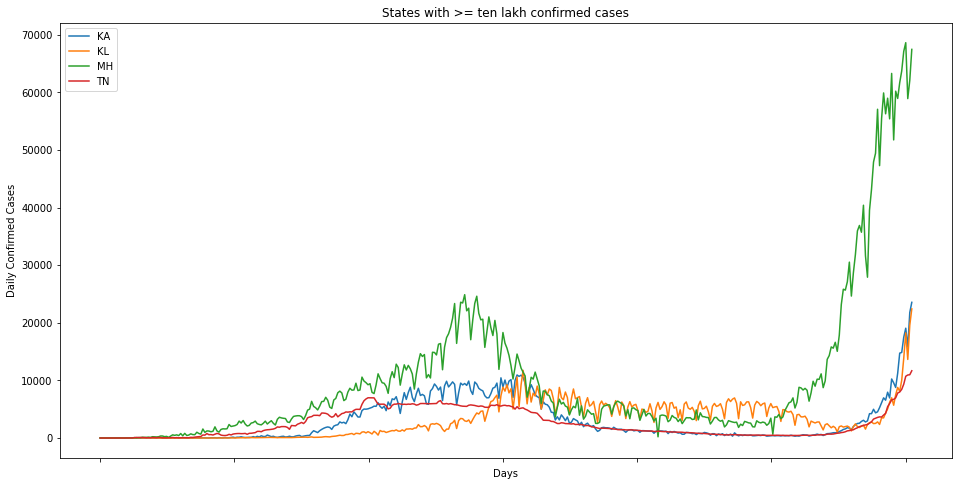

In [10]:
# States with >= ten lakh confirmed cases

states = []
for state in state_codes:
    if confirmed[state].sum() >= 1000000:
        states.append(state)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
g = sns.lineplot(data=confirmed[states], dashes=False)
g.set(xticklabels=[])
g.set(title="States with >= ten lakh confirmed cases")
g.set(xlabel="Days")
g.set(ylabel="Daily Confirmed Cases")
plt.show()

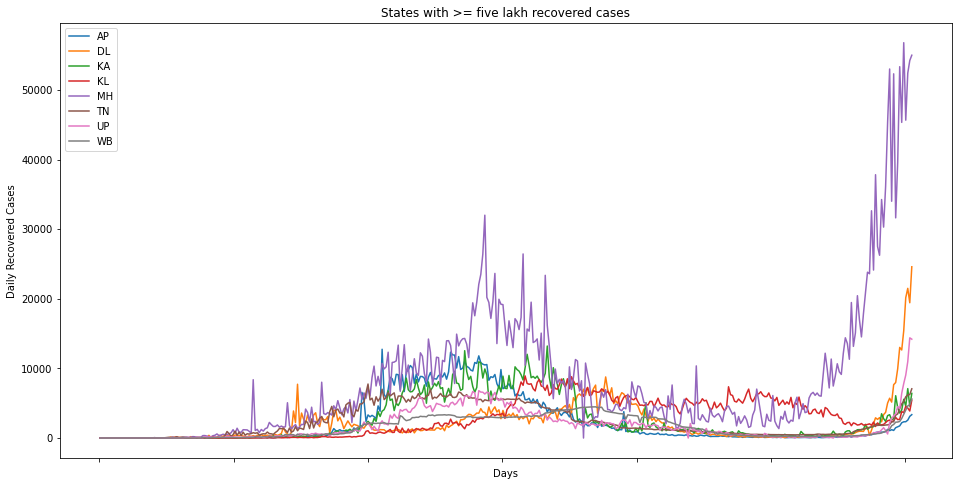

In [11]:
# States with >= five lakh recovered cases

states = []
for state in state_codes:
    if recovered[state].sum() >= 500000:
        states.append(state)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
g = sns.lineplot(data=recovered[states], dashes=False)
g.set(xticklabels=[])
g.set(title="States with >= five lakh recovered cases")
g.set(xlabel="Days")
g.set(ylabel="Daily Recovered Cases")
plt.show()

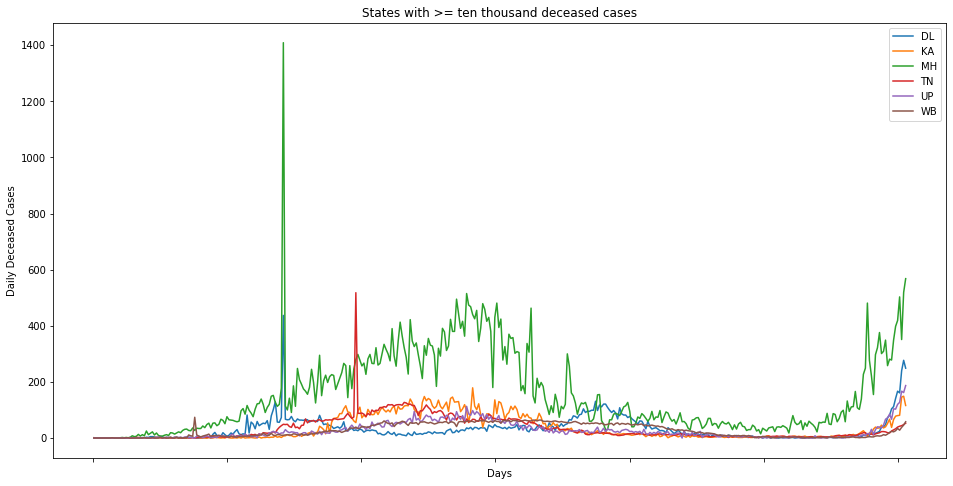

In [12]:
# States with >= ten thousand deceased cases

ten_thousand_deceased = []
for state in state_codes:
    if deceased[state].sum() > 10000:
        ten_thousand_deceased.append(state)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
g = sns.lineplot(data=deceased[ten_thousand_deceased], dashes=False)
g.set(xticklabels=[])
g.set(title="States with >= ten thousand deceased cases")
g.set(xlabel="Days")
g.set(ylabel="Daily Deceased Cases")
plt.show()

In [13]:
# Daily percentage contribution

daily_percentage = confirmed.copy()

for idx in range(len(daily_percentage)):
    daily_percentage.iloc[idx, 4:] = (daily_percentage.iloc[idx, 4:] / daily_percentage.iloc[idx, 3]) * 100

daily_percentage.drop(columns=["Date", "Status", "TT", "UN"], inplace=True)
display(daily_percentage)

,Date_YMD,AN,AP,AR,AS,BR,CH,CT,DN,DD,...,PY,PB,RJ,SK,TN,TG,TR,UP,UT,WB
0,2020-03-14,0.000000,1.234568,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,1.234568,3.703704,0.000000,1.234568,1.234568,0.000000,14.814815,0.000000,0.000000
3,2020-03-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,3.703704,0.000000,0.000000,7.407407,0.000000,3.703704,0.000000,0.000000
6,2020-03-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,6.666667,0.000000,0.000000,0.000000,0.000000,6.666667,0.000000,0.000000,6.666667,0.000000
9,2020-03-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,9.090909,0.000000,18.181818,0.000000,9.090909
12,2020-03-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,2.702703,8.108108,0.000000,2.702703,21.621622,0.000000,5.405405,2.702703,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1197,2021-04-17,0.016098,2.768930,0.007283,0.335767,3.016539,0.165201,6.164549,0.041396,0.0,...,0.274057,1.698384,3.467295,0.027597,3.581517,1.704134,0.022231,10.477012,1.056747,2.956362
1200,2021-04-18,0.021450,2.392906,0.007271,0.232310,3.159276,0.227221,4.488063,0.066894,0.0,...,0.241036,1.781410,3.730782,0.038173,3.898380,1.851576,0.025085,11.112363,0.956145,3.060753
1203,2021-04-19,0.012062,2.320206,0.025292,0.531900,2.913196,0.238130,5.382817,0.047081,0.0,...,0.219842,1.798423,4.656366,0.003502,4.257149,1.559904,0.012451,10.976915,0.840457,3.278561
1206,2021-04-20,0.015287,3.053012,0.020723,0.560868,3.551713,0.204508,5.308036,0.098857,0.0,...,0.216738,1.581710,4.144854,0.030914,3.732101,2.013147,0.020383,10.046711,1.023219,3.335655


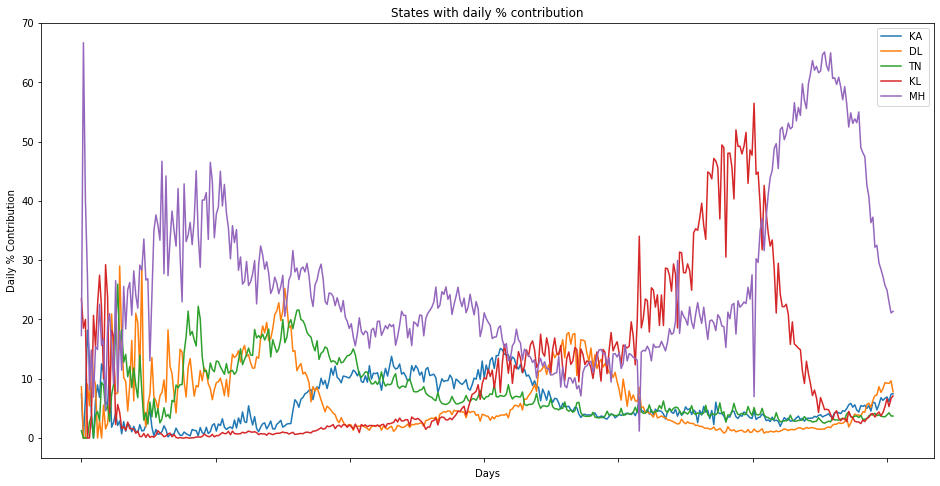

In [14]:
# Top 5 daily contributing states

daily_mean = dict.fromkeys(state_codes, 0)
for state in state_codes:
    daily_mean[state] = daily_percentage[state].mean()

top_five_daily = dict(sorted(daily_mean.items(), key=lambda item: item[1]))
top_five_daily = list(top_five_daily.keys())[-5:]

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
g4 = sns.lineplot(data=daily_percentage[top_five_daily], dashes=False)
g4.set(xticklabels=[])
g4.set(title="States with daily % contribution")
g4.set(xlabel="Days")
g4.set(ylabel="Daily % Contribution")
plt.show()

If you found this notebook helpful please give a thumbs up!